In [1]:
from collections import defaultdict
from common import NWSL, Fonts, Images
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [2]:
df = pd.read_csv("schedule.csv")
df

,date,home,score,away
0,2022-04-29,LA,2-1,NC
1,2022-04-30,POR,3-0,KC
2,2022-05-01,WAS,2-1,RGN
3,2022-05-01,HOU,0-1,SD
4,2022-05-01,ORL,0-3,NJNY
...,...,...,...,...
127,2022-10-01,NJNY,NaN,POR
128,2022-10-01,WAS,NaN,HOU
129,2022-10-01,LOU,NaN,KC
130,2022-10-01,RGN,NaN,ORL


In [3]:
# Convert scores to tuples
df.loc[~df["score"].isnull(), "score"] = (
    df.loc[~df["score"].isnull(), "score"]
    .str.split("-")
    .apply(lambda x: (int(x[0]), int(x[1])))
)
df

,date,home,score,away
0,2022-04-29,LA,"(2, 1)",NC
1,2022-04-30,POR,"(3, 0)",KC
2,2022-05-01,WAS,"(2, 1)",RGN
3,2022-05-01,HOU,"(0, 1)",SD
4,2022-05-01,ORL,"(0, 3)",NJNY
...,...,...,...,...
127,2022-10-01,NJNY,NaN,POR
128,2022-10-01,WAS,NaN,HOU
129,2022-10-01,LOU,NaN,KC
130,2022-10-01,RGN,NaN,ORL


In [4]:
def calc_table(matches):
    m = matches.copy()

    # Calculate home/away goals
    m["home_goals"] = m["score"].str[0]
    m["away_goals"] = m["score"].str[1]

    # Calculate home/away points
    m["home_points"] = np.where(m["home_goals"] > m["away_goals"], 3, 0) + np.where(
        ~m["home_goals"].isnull() * m["home_goals"] == m["away_goals"], 1, 0
    )
    m["away_points"] = np.where(m["home_goals"] < m["away_goals"], 3, 0) + np.where(
        ~m["home_goals"].isnull() * m["home_goals"] == m["away_goals"], 1, 0
    )

    # Calculate home/away wins
    m["home_wins"] = np.where(m["home_goals"] > m["away_goals"], 1, 0)
    m["away_wins"] = np.where(m["home_goals"] < m["away_goals"], 1, 0)
    
    # Calculate home/away ties
    m["home_ties"] = np.where(m["home_points"] == 1, 1, 0)
    m["away_ties"] = np.where(m["away_points"] == 1, 1, 0)
    
    # Calculate home/away losses
    m["home_losses"] = np.where(m["home_points"] == 0, 1, 0)
    m["away_losses"] = np.where(m["away_points"] == 0, 1, 0)

    # Combine home/away results
    results = pd.concat(
        [
            m[["home", "home_points", "home_goals", "away_goals", "home_wins", "home_ties", "home_losses"]].rename(
                columns={
                    "home": "team",
                    "home_points": "points",
                    "home_goals": "goals_for",
                    "away_goals": "goals_against",
                    "home_wins": "wins",
                    "home_ties": "ties",
                    "home_losses": "losses",
                }
            ),
            m[["away", "away_points", "away_goals", "home_goals", "away_wins", "away_ties", "away_losses"]].rename(
                columns={
                    "away": "team",
                    "away_points": "points",
                    "away_goals": "goals_for",
                    "home_goals": "goals_against",
                    "away_wins": "wins",
                    "away_ties": "ties",
                    "away_losses": "losses",
                }
            ),
        ]
    ).fillna(0)
    results[["goals_for", "goals_against"]] = results[
        ["goals_for", "goals_against"]
    ].apply(pd.to_numeric)

    # Calculate the table
    table = results.groupby(["team"]).agg(
        {"points": "sum", "goals_for": "sum", "goals_against": "sum", "wins": "sum", "ties": "sum", "losses": "sum"}
    )
    table["goals_diff"] = table["goals_for"] - table["goals_against"]
    table = table.reset_index()

    # Calculate tiebreakers for teams tied on points/goal differential/wins
    # - Goal differential
    # - Total wins
    # - Goals scored
    # - Head to head points
    # - Head to head goals scored
    table["tie_points"] = 0
    table["tie_goals"] = 0
    for index, row in table.iterrows():
        team = row["team"]
        tied = table[
            (table["team"] != team)
            & (table["points"] == row["points"])
            & (table["goals_diff"] == row["goals_diff"])
            & (table["wins"] == row["wins"])
        ].reset_index(drop=True)
        if len(tied.index) > 1:
            table.at[index, "tie_points"] = random.randint(0, 10)
        elif len(tied.index) == 1:
            opp = tied.iloc[0]["team"]
            subset = m[m["home"].isin([team, opp]) & m["away"].isin([team, opp])]
            for _, game in subset.iterrows():
                game = game.fillna(0)
                game[["home_goals", "away_goals"]] = game[
                    ["home_goals", "away_goals"]
                ].apply(pd.to_numeric)
                if game["home"] == team:
                    table.at[index, "tie_points"] += game["home_points"]
                    table.at[index, "tie_goals"] += game["home_goals"]
                else:
                    table.at[index, "tie_points"] += game["away_points"]
                    table.at[index, "tie_goals"] += game["away_goals"]

    # Sort final table
    table = table.sort_values(
        by=["points", "goals_diff", "wins", "goals_for", "tie_points", "tie_goals"],
        ascending=False,
    ).reset_index(drop=True)
    table.index = table.index + 1

    return table

In [5]:
# Current table
calc_table(df.dropna()).to_csv('table.csv')
calc_table(df.dropna())

,team,points,goals_for,goals_against,wins,ties,losses,goals_diff,tie_points,tie_goals
1,POR,38,46,21,10,8,3,25,0,0
2,RGN,37,29,19,10,7,4,10,0,0
3,KC,36,29,28,10,6,5,1,0,0
4,SD,35,32,21,10,5,6,11,0,0
5,HOU,33,33,26,9,6,6,7,0,0
6,NC,31,46,33,9,4,8,13,0,0
7,CHI,30,32,28,8,6,7,4,0,0
8,LA,29,23,25,8,5,8,-2,0,0
9,ORL,22,22,42,5,7,9,-20,0,0
10,LOU,20,22,35,4,8,9,-13,0,0


In [6]:
# Given scores for the last 6 games, calculate the table
def process_table_for_scores(scores):
    df_copy = df.copy()
    df_copy.loc[df_copy["score"].isnull(), "score"] = scores
    rank = calc_table(df_copy)
    return rank

table = process_table_for_scores([(0,0), (0,0), (0,0), (0,0), (0,0), (0,0)])
table

,team,points,goals_for,goals_against,wins,ties,losses,goals_diff,tie_points,tie_goals
1,POR,39,46,21,10,9,3,25,0,0
2,RGN,38,29,19,10,8,4,10,0,0
3,KC,37,29,28,10,7,5,1,0,0
4,SD,36,32,21,10,6,6,11,0,0
5,HOU,34,33,26,9,7,6,7,0,0
6,NC,32,46,33,9,5,8,13,0,0
7,CHI,31,32,28,8,7,7,4,0,0
8,LA,30,23,25,8,6,8,-2,0,0
9,ORL,23,22,42,5,8,9,-20,0,0
10,LOU,21,22,35,4,9,9,-13,0,0


In [7]:
times = (
    [str(i) + "'" for i in range(1, 46)]
    + ["45+" + str(i) + "'" for i in range(1, 5)]
    + [str(i) + "'" for i in range(45, 91)]
    + ["90+" + str(i) + "'" for i in range(1, 4)]
)
goals = {
    "8'": ["RGN"],
    "14'": ["HOU"],
    "24'": ["RGN"],
    "31'": ["RGN"],
    "36'": ["WAS"],
    "39'": ["NJNY"],
    "44'": ["POR"],
    "45+1'": ["POR"],
    "45+4'": ["CHI"],
    "53'": ["POR"],
    "56'": ["NJNY"],
    "58'": ["HOU"],
    "74'": ["NJNY"],
    "77'": ["CHI"],
    "90+2'": ["LOU"],
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


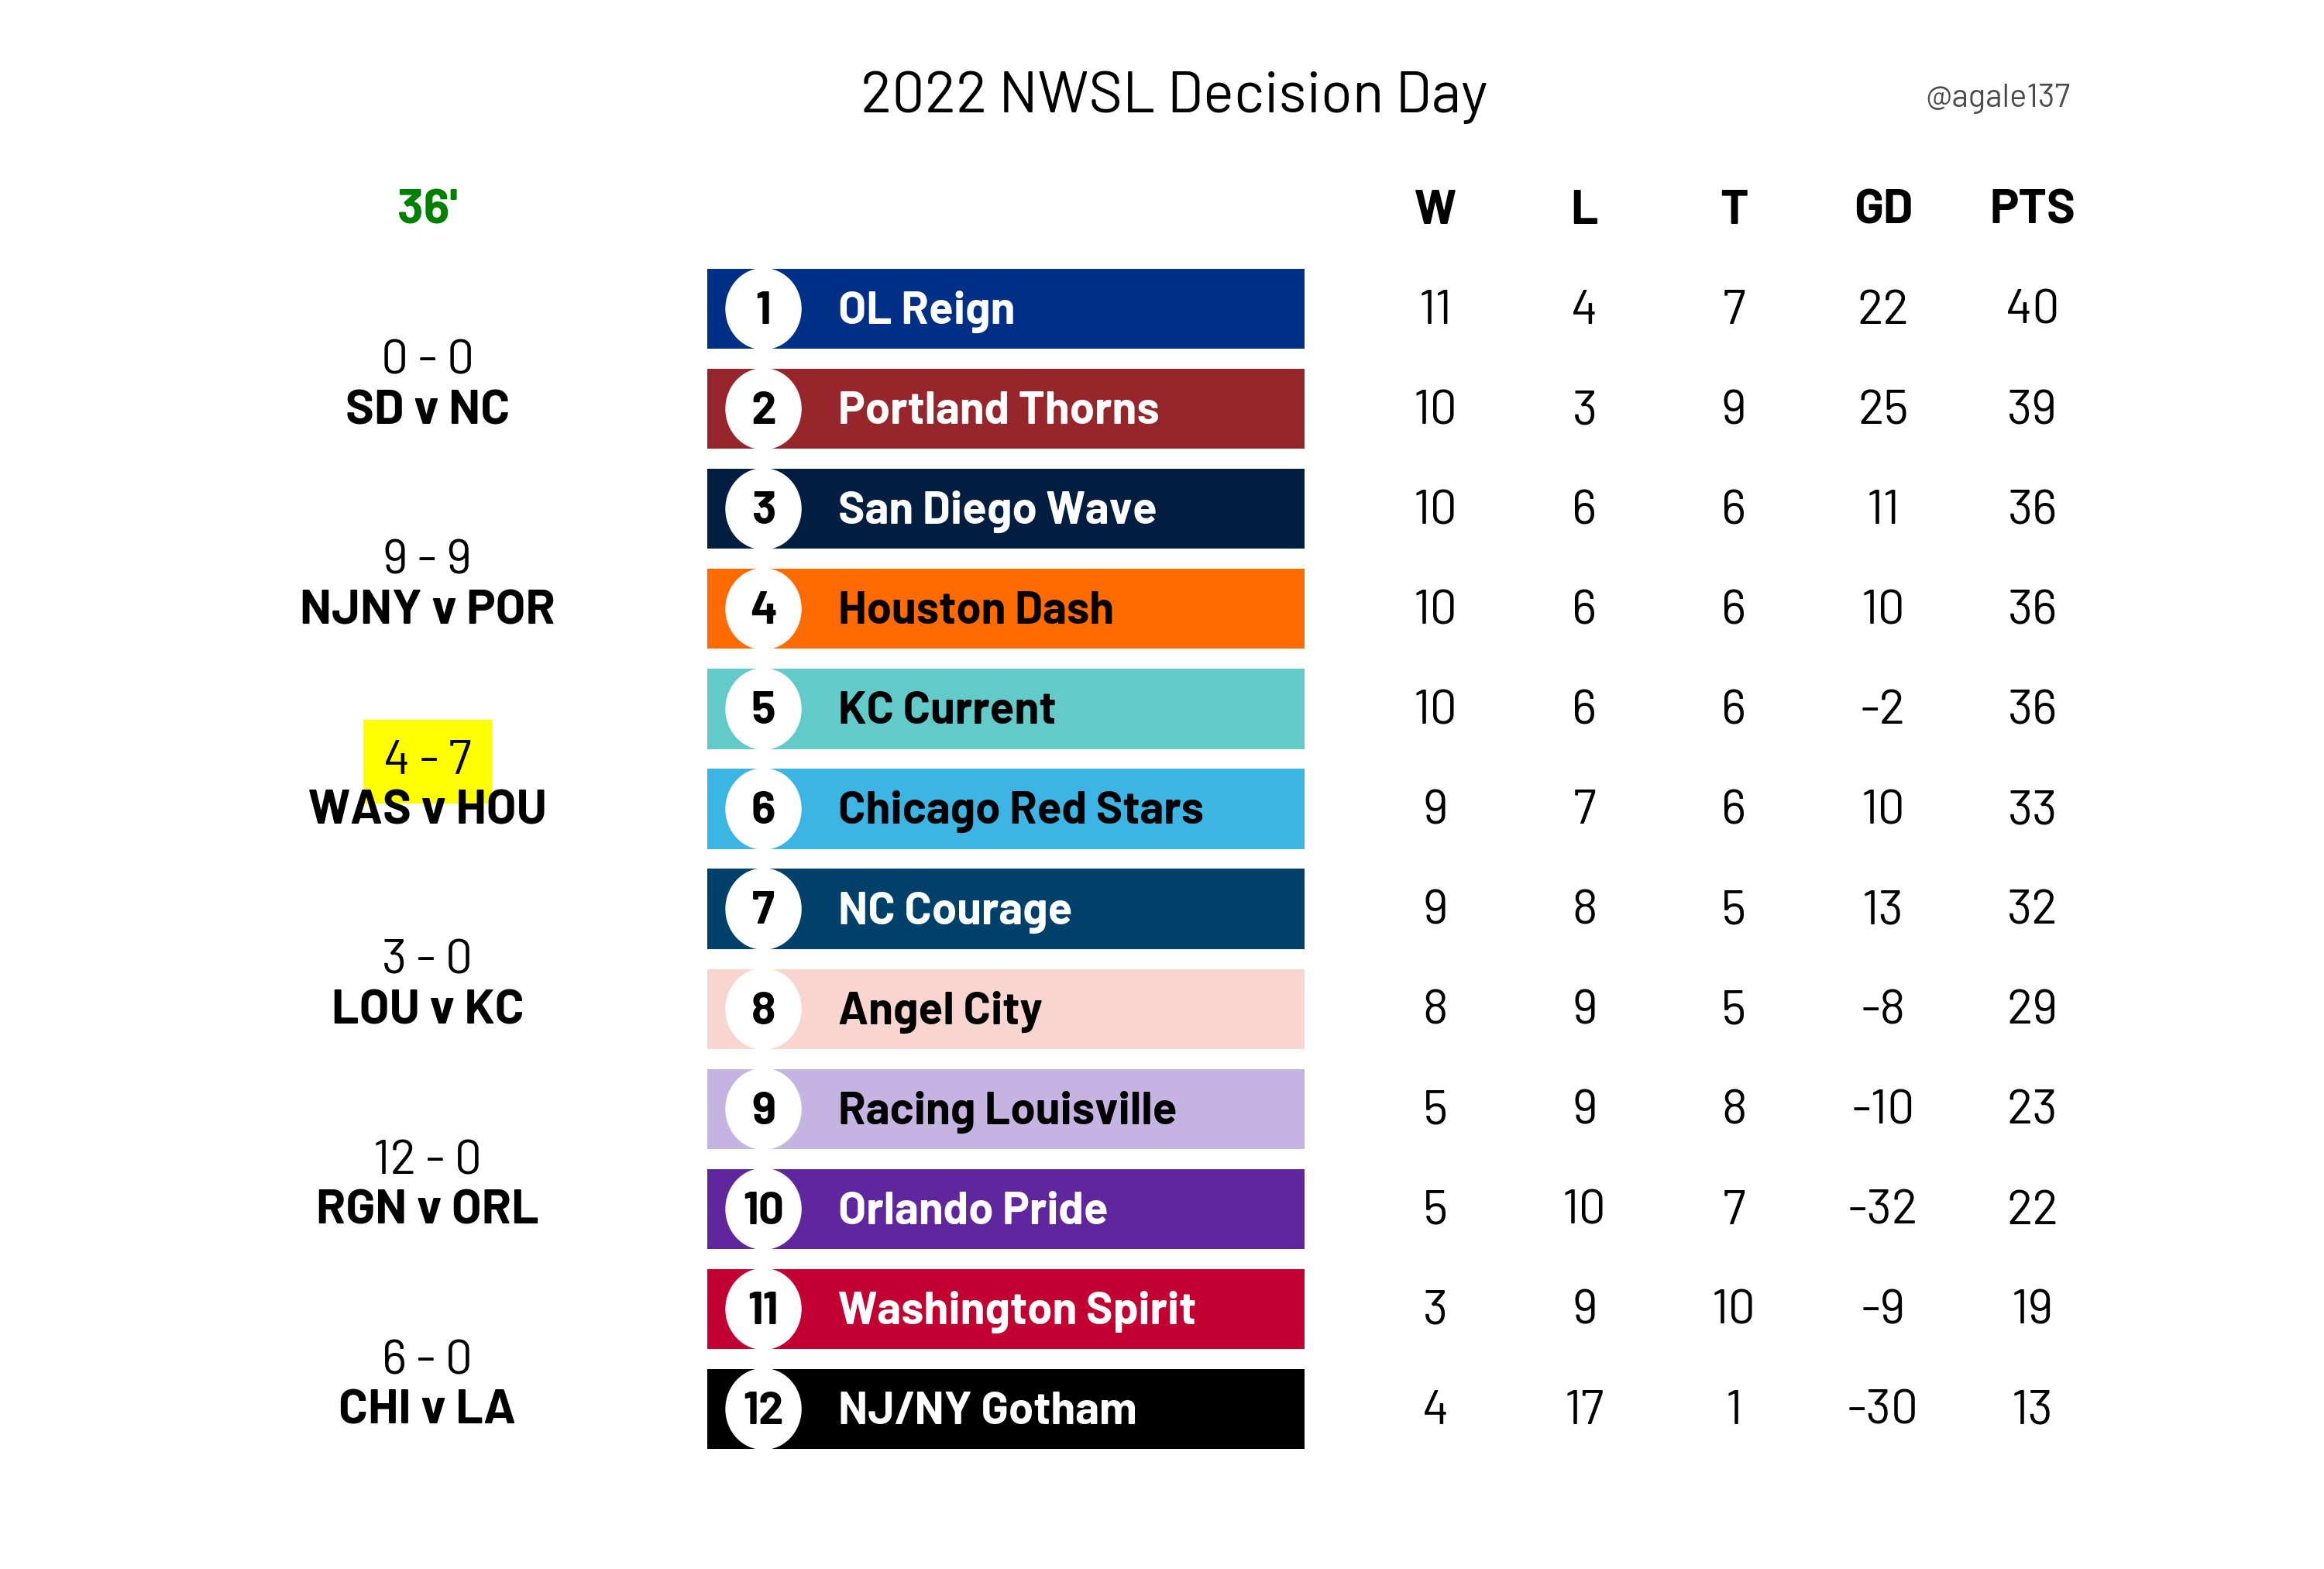

In [10]:
%matplotlib notebook

decision_matches = [
    ("SD", "NC"),
    ("NJNY", "POR"),
    ("WAS", "HOU"),
    ("LOU", "KC"),
    ("RGN", "ORL"),
    ("CHI", "LA"),
]

scores = {
    "SD": 0,
    "NC": 0,
    "NJNY": 0,
    "POR": 0,
    "WAS": 0,
    "HOU": 0,
    "LOU": 0,
    "KC": 0,
    "RGN": 0,
    "ORL": 0,
    "CHI": 0,
    "LA": 0,
}

table = process_table_for_scores([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)])

# Width of the table cells
cw = 0.4

# Draw the plot
plt.clf()
plt.rcParams["figure.figsize"] = (20, 13.5)
plt.figure(dpi=1200, facecolor="white")
fig, ax = plt.subplots()
fig.tight_layout()
fig.patch.set_facecolor("white")
fig.gca().invert_yaxis()


def animate(minute):
    if minute >= len(times):
        return

    # Update data
    if times[minute] in goals:
        for g in goals[times[minute]]:
            scores[g] += 1

    table = process_table_for_scores(
        list(map(lambda x: (scores[x[0]], scores[x[1]]), decision_matches))
    )

    ax.cla()  # clear the previous image

    # Axes
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlim([0, 6])
    plt.ylim([13, -2])

    # Title
    plt.text(
        3,
        -1,
        "2022 NWSL Decision Day",
        color="black",
        fontsize=36,
        fontproperties=Fonts.BARLOW,
        ha="center",
        va="bottom",
    )

    # Plot the table headers
    for j, stat in enumerate(["W", "L", "T", "GD", "PTS"]):
        plt.text(
            3.7 + j * cw,
            0,
            stat,
            color="black",
            fontsize=30,
            fontproperties=Fonts.BARLOW_BOLD,
            ha="center",
        )

    # Plot the scorecards
    for i, match in enumerate(decision_matches):
        # Flash yellow background for a goal
        bc = "white"
        if times[minute] in goals:
            if match[0] in goals[times[minute]] or match[1] in goals[times[minute]]:
                bc = "yellow"
        plt.text(
            1,
            i * 2 + 1.5,
            str(scores[match[0]]) + " - " + str(scores[match[1]]),
            color="black",
            backgroundcolor=bc,
            fontsize=30,
            fontproperties=Fonts.BARLOW,
            ha="center",
        )
        plt.text(
            1,
            i * 2 + 2.0,
            match[0] + " v " + match[1],
            color="black",
            fontsize=30,
            fontproperties=Fonts.BARLOW_BOLD,
            ha="center",
        )

    # Plot the table data
    for i, row in table.iterrows():
        # Background color for team
        ax.add_patch(
            Rectangle((1.75, i - 0.6 + 0.05), 1.6, 0.8, fc=NWSL.COLORS[row["team"]])
        )

        # Background circle for rank
        ax.add_patch(Ellipse((1.9, i - 0.15), 0.2, 0.8, color="white"))

        # Team ramk
        plt.text(
            1.9,
            i,
            str(i),
            color="black",
            fontsize=28,
            fontproperties=Fonts.BARLOW_BOLD,
            ha="center",
        )

        # Team name
        plt.text(
            2.1,
            i,
            NWSL.NAMES[row["team"]],
            color=NWSL.TEXT_COLORS[row["team"]],
            fontsize=28,
            fontproperties=Fonts.BARLOW_BOLD,
            ha="left",
        )

        for j, stat in enumerate(["wins", "losses", "ties", "goals_diff", "points"]):
            plt.text(
                3.7 + j * cw,
                i,
                row[stat],
                color="black",
                fontsize=30,
                fontproperties=Fonts.BARLOW,
                ha="center",
            )

    # Plot the time
    plt.text(
        1,
        0,
        times[minute],
        color="green",
        fontsize=30,
        fontproperties=Fonts.BARLOW_BOLD,
        ha="center",
    )
    
    # Twitter logo and username
    plt.text(
        0.9,
        0.95,
        "@agale137",
        transform=ax.transAxes,
        color="black",
        fontsize=20,
        alpha=0.7,
        fontproperties=Fonts.BARLOW,
        va="center",
        ha="right",
    )

anim = animation.FuncAnimation(
    fig, animate, frames=len(times) * 2, interval=1, blit=False
)
anim.save("decision_day.gif", writer=PillowWriter(fps=10))